## Chest-X-Rays-Analysis

Identifying Pneumonia in Chest X-Rays by Image-Based Deep Learning

### Import packages

In [22]:
# Import data visualisation and manipulation libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import style
import seaborn as sns
import pprint
import cv2

# Import standard libraries
import os
import random

# File and directory access
from pathlib import Path 
import glob

# Import ML libraries
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configuration of plotting and printing settings 
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
pd.options.display.max_colwidth = 100

# Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
IMG_SIZE = 256
SEED = 42

### Import dataset

Dataset source: https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images

In [3]:
# Path to the data directory
main_path = Path('../Chest-X-Rays-Analysis/data')

# Path to train directory
train_path = main_path / 'train'

# Path to test directory
test_path = main_path / 'test'

# Get the paths to the images in normal and pneumonia sub-directories
train_normal = list((train_path / 'NORMAL').glob('*.jpeg'))
train_pneumonia = list((train_path / "PNEUMONIA").glob('*.jpeg'))
test_normal = list((test_path / 'NORMAL').glob('*.jpeg'))
test_pneumonia = list((test_path / "PNEUMONIA").glob('*.jpeg'))

In [4]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , 
                                        ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

In [5]:
df_train

,class,image
0,Normal,..\Chest-X-Rays-Analysis\data\train\NORMAL\NORMAL-1003233-0001.jpeg
1,Normal,..\Chest-X-Rays-Analysis\data\train\NORMAL\NORMAL-1012843-0001.jpeg
2,Normal,..\Chest-X-Rays-Analysis\data\train\NORMAL\NORMAL-1014768-0001.jpeg
3,Normal,..\Chest-X-Rays-Analysis\data\train\NORMAL\NORMAL-1023731-0001.jpeg
4,Normal,..\Chest-X-Rays-Analysis\data\train\NORMAL\NORMAL-1029510-0001.jpeg
...,...,...
5227,Pneumonia,..\Chest-X-Rays-Analysis\data\train\PNEUMONIA\VIRUS-9934736-0003.jpeg
5228,Pneumonia,..\Chest-X-Rays-Analysis\data\train\PNEUMONIA\VIRUS-9947411-0002.jpeg
5229,Pneumonia,..\Chest-X-Rays-Analysis\data\train\PNEUMONIA\VIRUS-9962961-0002.jpeg
5230,Pneumonia,..\Chest-X-Rays-Analysis\data\train\PNEUMONIA\VIRUS-9963654-0001.jpeg


In [6]:
df_test

,class,image
0,Normal,..\Chest-X-Rays-Analysis\data\test\NORMAL\NORMAL-1049278-0001.jpeg
1,Normal,..\Chest-X-Rays-Analysis\data\test\NORMAL\NORMAL-1110860-0001.jpeg
2,Normal,..\Chest-X-Rays-Analysis\data\test\NORMAL\NORMAL-11419-0001.jpeg
3,Normal,..\Chest-X-Rays-Analysis\data\test\NORMAL\NORMAL-115218-0001.jpeg
4,Normal,..\Chest-X-Rays-Analysis\data\test\NORMAL\NORMAL-1160949-0001.jpeg
...,...,...
619,Pneumonia,..\Chest-X-Rays-Analysis\data\test\PNEUMONIA\VIRUS-9584831-0001.jpeg
620,Pneumonia,..\Chest-X-Rays-Analysis\data\test\PNEUMONIA\VIRUS-9671740-0001.jpeg
621,Pneumonia,..\Chest-X-Rays-Analysis\data\test\PNEUMONIA\VIRUS-9783315-0001.jpeg
622,Pneumonia,..\Chest-X-Rays-Analysis\data\test\PNEUMONIA\VIRUS-9890836-0001.jpeg


### Data exploration

Dataset consist of two classes: Normal and Pneumonia. 
There are 5232 images in train set and 624 images in test set.

Data distribution in train set:

In [7]:
def plot_distribution_by(data, group, title):
    
    plt.figure(figsize=(7,5))

    ax = sns.countplot(x=group, data=data, palette="husl")

    plt.title(title, fontsize=15)
    plt.xlabel("Class", fontsize= 14)
    plt.ylabel("Samples", fontsize= 14)
    plt.ylim(0, (data.groupby(group).count().max()[0] * 1.2))
    plt.xticks(list(range(len(df_train["class"].unique()))), data[group].unique(), fontsize = 13)

    for p in ax.patches:
        ax.annotate((str(p.get_height()) + ", " + str(p.get_height() / len(data) * 100)[0:5] + "%"), 
                    (p.get_x() + 0.25, p.get_height() * 1.05), fontsize = 14)

    plt.show()
    
    return

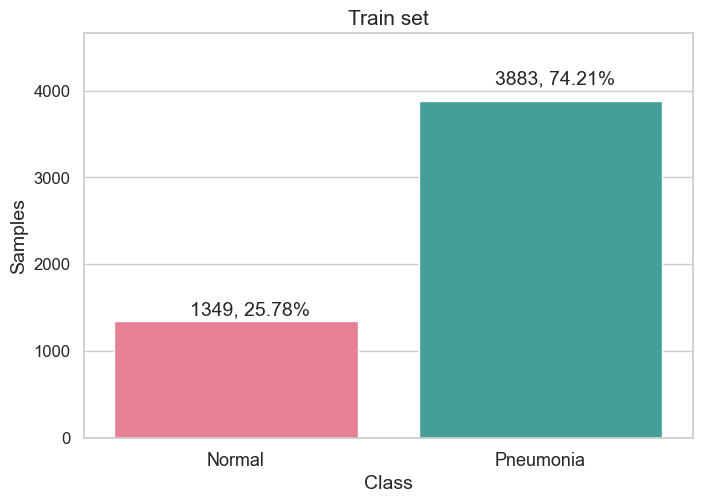

In [8]:
plot_distribution_by(df_train, "class", "Train set")

Data distribution in test set:

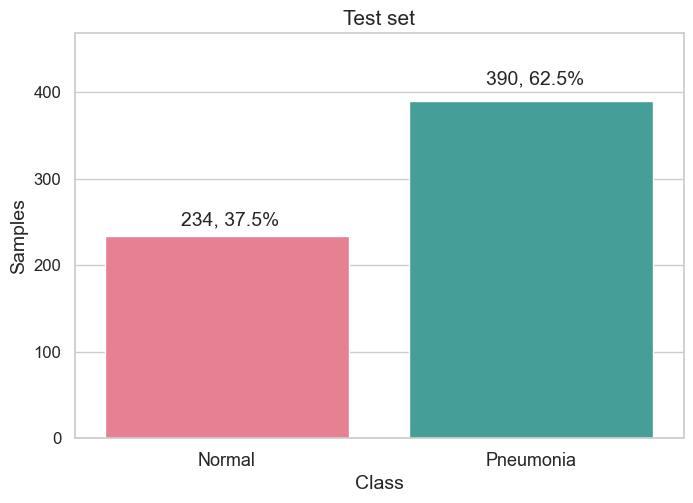

In [9]:
plot_distribution_by(df_test, "class", "Test set")

Both sets seem to be imbalanced having more samples from "Pneumonia" class. Let's see some examples from each set.

In [10]:
def img_print(file_list, path):
    
    plt.figure(figsize=(10, 10))
    i = 1
    
    for file in file_list:
        file_path = path / file
        plt.subplot(2, 3, i)
        img = cv2.imread(str(file_path))
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        plt.imshow(img)
        plt.axis("off")
        i = i + 1
        
    plt.tight_layout()
    plt.show()
    
    return

TRAIN DATASET

Printing 6 normal random images

['NORMAL-4093513-0001.jpeg',
 'NORMAL-9275636-0001.jpeg',
 'NORMAL-1513368-0001.jpeg',
 'NORMAL-3360834-0001.jpeg',
 'NORMAL-1029510-0001.jpeg',
 'NORMAL-2659844-0001.jpeg']


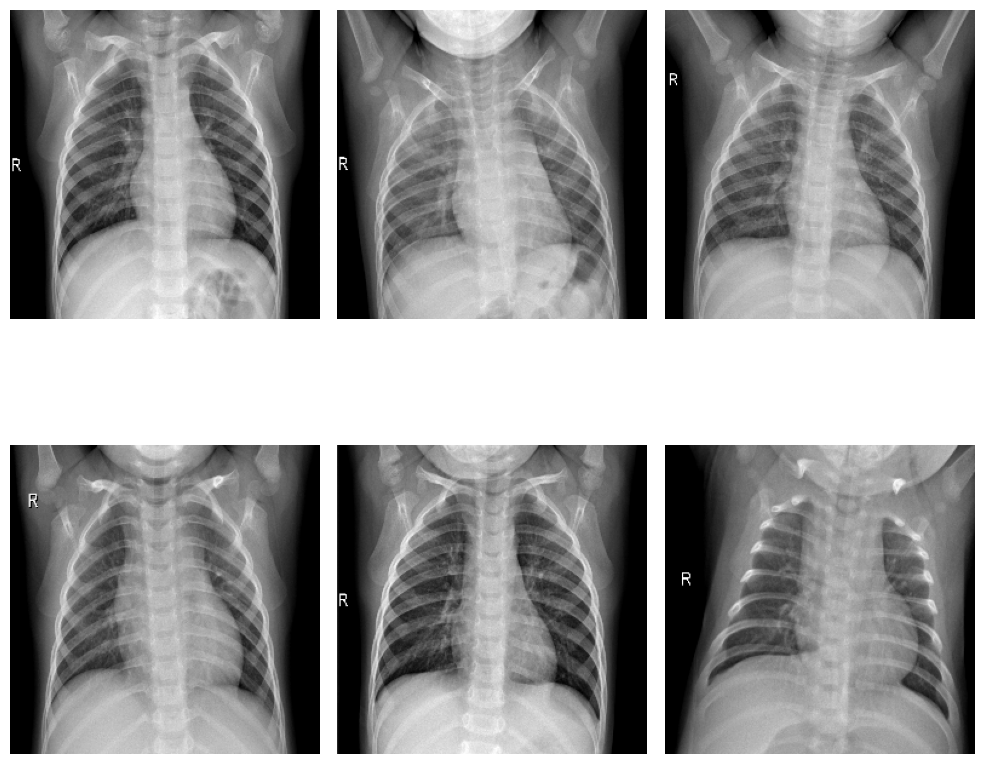


Printing 6 pneumonia random images

['BACTERIA-1513937-0001.jpeg',
 'BACTERIA-8660561-0005.jpeg',
 'VIRUS-249675-0002.jpeg',
 'VIRUS-1116080-0002.jpeg',
 'BACTERIA-9988673-0002.jpeg',
 'BACTERIA-5442456-0001.jpeg']


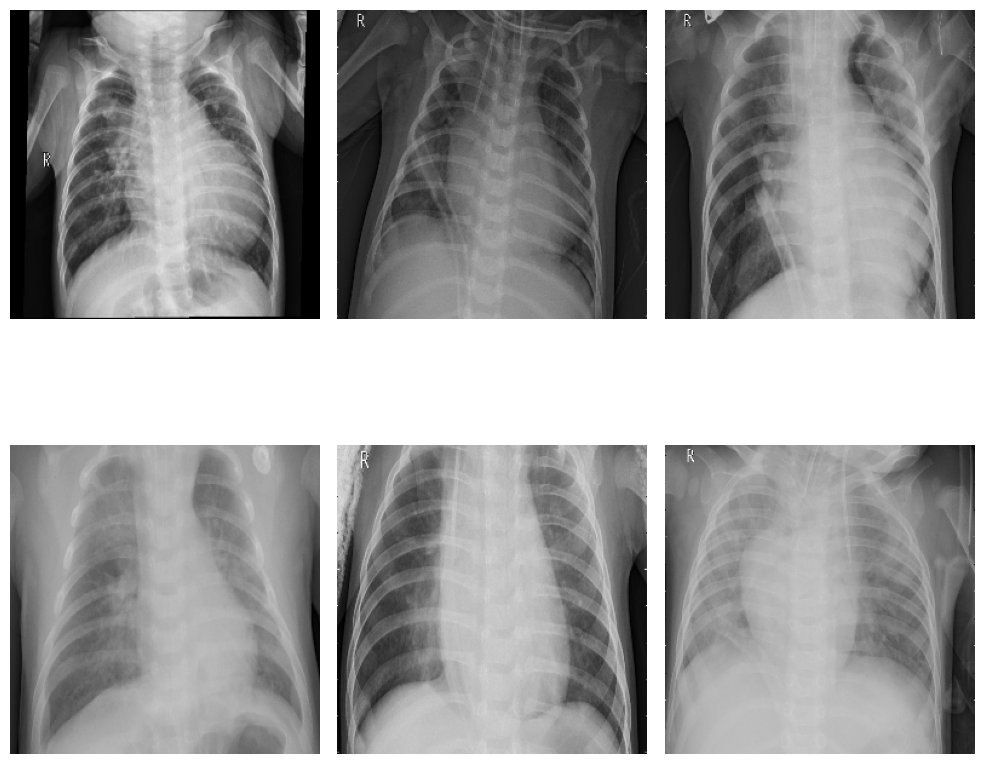


TEST DATASET

Printing 6 normal random images

['NORMAL-7165123-0001.jpeg',
 'NORMAL-6332708-0001.jpeg',
 'NORMAL-4852815-0001.jpeg',
 'NORMAL-7082548-0001.jpeg',
 'NORMAL-4511610-0001.jpeg',
 'NORMAL-3170711-0001.jpeg']


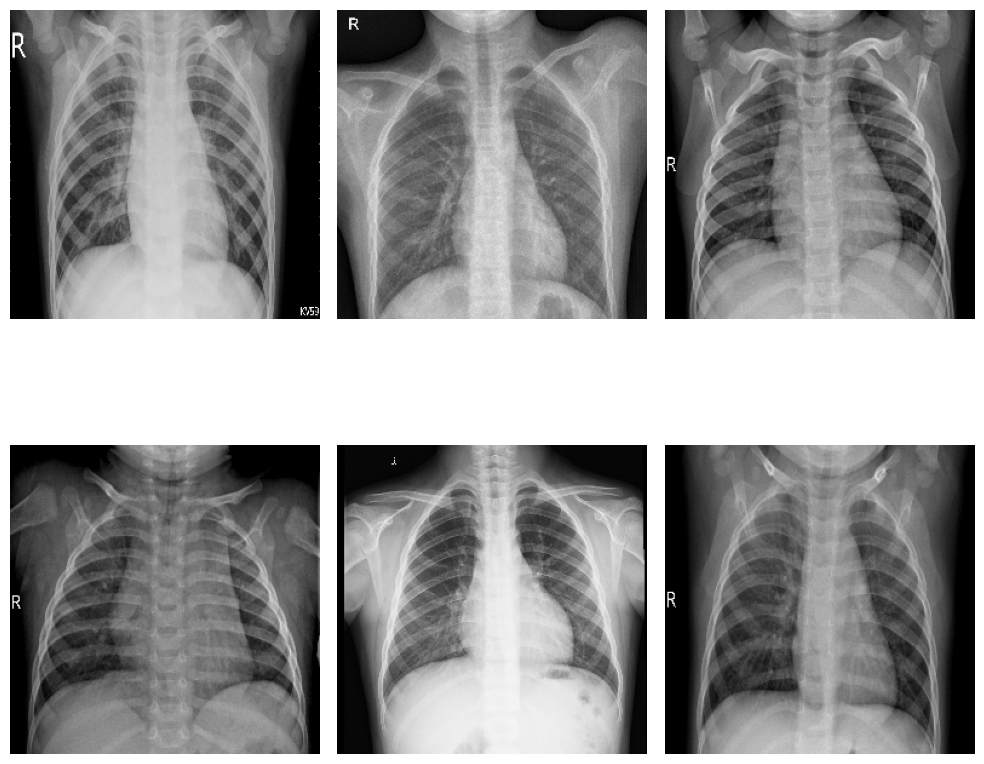


Printing 6 pneumonia random images

['VIRUS-9564688-0002.jpeg',
 'BACTERIA-5240350-0002.jpeg',
 'BACTERIA-8190872-0005.jpeg',
 'VIRUS-9018258-0001.jpeg',
 'BACTERIA-9673743-0002.jpeg',
 'BACTERIA-1135262-0001.jpeg']


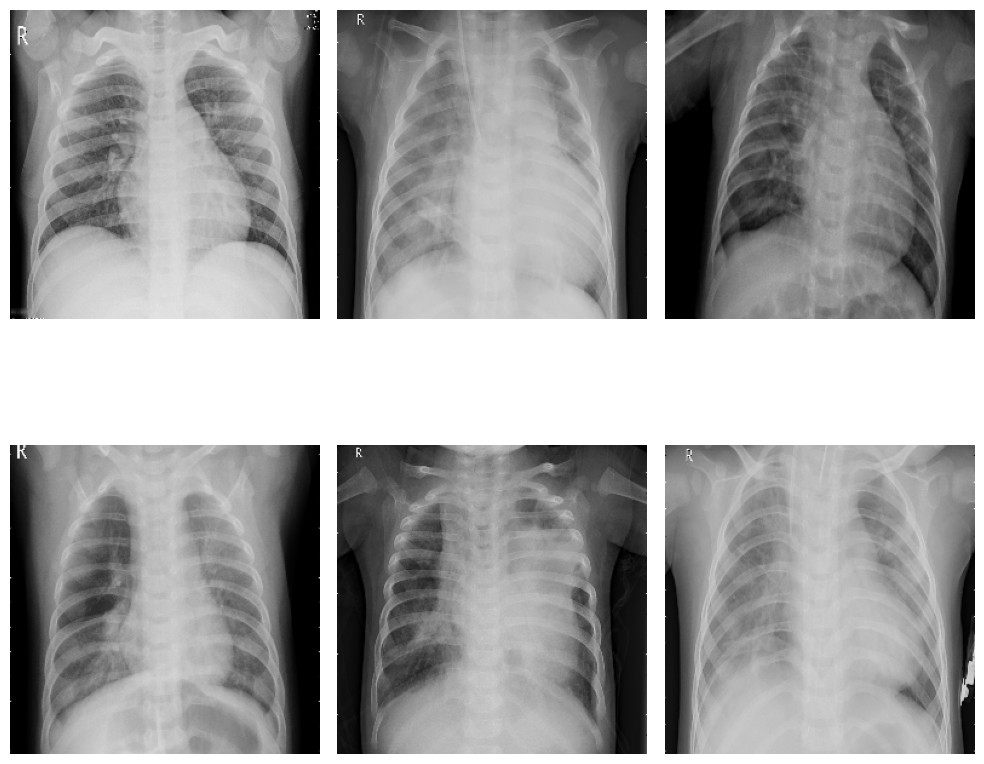

In [16]:
for folder in [train_path, test_path]:
    if folder == train_path:
        print("TRAIN DATASET")
    else:
        print("\nTEST DATASET")
    for subfolder in ["NORMAL", "PNEUMONIA"]:
        path = folder / subfolder
        samples = 6 # number of samples to plot
        random_choices = random.choices(os.listdir(path), k=samples)
        print("\nPrinting " + str(samples) + str.lower(" " + subfolder) + " random images\n")
        pprint.pprint(random_choices)
        img_print(random_choices, path)

### Data preparation

Stratified split on the orginal train dataset is being used to create a validation set. 

In [17]:
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = SEED, stratify = df_train['class'])

In [18]:
train_df

,class,image
3566,Pneumonia,..\Chest-X-Rays-Analysis\data\train\PNEUMONIA\BACTERIA-8718799-0001.jpeg
2866,Pneumonia,..\Chest-X-Rays-Analysis\data\train\PNEUMONIA\BACTERIA-6295192-0003.jpeg
2681,Pneumonia,..\Chest-X-Rays-Analysis\data\train\PNEUMONIA\BACTERIA-5615122-0001.jpeg
1199,Normal,..\Chest-X-Rays-Analysis\data\train\NORMAL\NORMAL-9031828-0001.jpeg
4619,Pneumonia,..\Chest-X-Rays-Analysis\data\train\PNEUMONIA\VIRUS-5822550-0001.jpeg
...,...,...
3476,Pneumonia,..\Chest-X-Rays-Analysis\data\train\PNEUMONIA\BACTERIA-8467199-0001.jpeg
678,Normal,..\Chest-X-Rays-Analysis\data\train\NORMAL\NORMAL-5634312-0001.jpeg
1560,Pneumonia,..\Chest-X-Rays-Analysis\data\train\PNEUMONIA\BACTERIA-1797366-0001.jpeg
2769,Pneumonia,..\Chest-X-Rays-Analysis\data\train\PNEUMONIA\BACTERIA-5965088-0001.jpeg


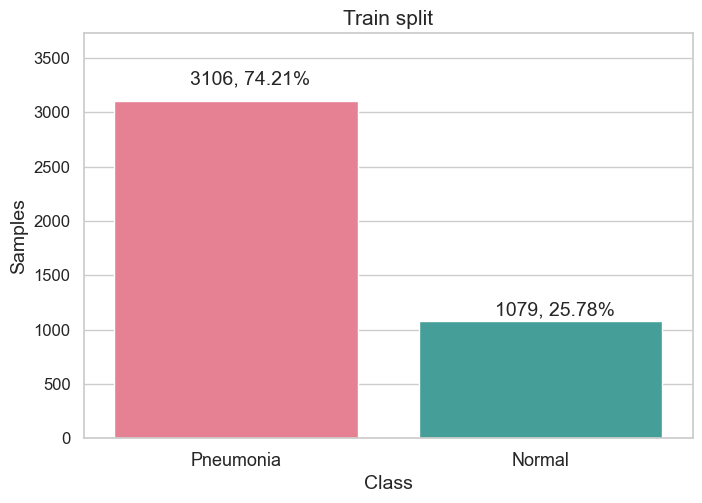

In [19]:
plot_distribution_by(train_df, "class", "Train split")

In [20]:
val_df

,class,image
2945,Pneumonia,..\Chest-X-Rays-Analysis\data\train\PNEUMONIA\BACTERIA-654117-0001.jpeg
4878,Pneumonia,..\Chest-X-Rays-Analysis\data\train\PNEUMONIA\VIRUS-7603659-0001.jpeg
3177,Pneumonia,..\Chest-X-Rays-Analysis\data\train\PNEUMONIA\BACTERIA-7512869-0002.jpeg
972,Normal,..\Chest-X-Rays-Analysis\data\train\NORMAL\NORMAL-7436212-0002.jpeg
3059,Pneumonia,..\Chest-X-Rays-Analysis\data\train\PNEUMONIA\BACTERIA-7022864-0004.jpeg
...,...,...
253,Normal,..\Chest-X-Rays-Analysis\data\train\NORMAL\NORMAL-2699389-0002.jpeg
4315,Pneumonia,..\Chest-X-Rays-Analysis\data\train\PNEUMONIA\VIRUS-3896078-0002.jpeg
687,Normal,..\Chest-X-Rays-Analysis\data\train\NORMAL\NORMAL-566227-0001.jpeg
3417,Pneumonia,..\Chest-X-Rays-Analysis\data\train\PNEUMONIA\BACTERIA-8313249-0001.jpeg


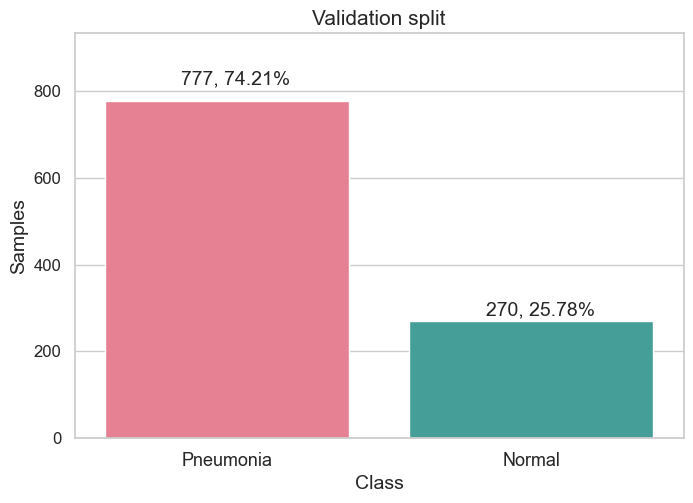

In [21]:
plot_distribution_by(val_df, "class", "Validation split")

I'll use data augmentation to mitigate the problem of having low number of samples in dataset. It won't affect the ratio of positive to negative cases. It may help the model to tackle the imbalance problem by presenting it larger number of cases so it can find the patter more easily. 
All of the images will be resized. For data augmentation I'll consider only rotate and zoom operations. Other changes like shearing, flipping or changing brightness and contrast level could cause that representation of dataset would be not true anymore. 

### TODO

1) Fix data imbalances after buidling first model